# Sparkify Project

### Project Overview
A common challenge for data scientists is predicting customer churn. Understanding and predicting whether or not a user will churn is beneficial to the business because they can take actions to combat this and improve their business performance. Customer churn analysis also benefits the users because businesses will try to improve customer services and experiences based on insights gained from data science.

This project focuses on focuses on predicting customer churn from a digital music streaming service called Sparkify. The full dataset is 12GB and consists of data about their users and their engagement with the platform. This blog post presents the approach I used for the analysis, methodology, and drawing conclusions to predict customer churn.

### Problem Statement
The goal of this project is to implement data-driven strategies to predict customer churn to improve business performance and customer experiences. Given the size of the full dataset, we will use a 128MB subset of it and perform our analysis on that using a standalone Spark framework.

### Performance Metrics
To evaluate our machine learning models, the accuracy and F1 score will be used as performance metrics. Accuracy is simply the measure of all correctly identified observations over the number of total observations. The F1 score is the harmonic mean of Precision and Recall and takes into account of class imbalances which we have in our Sparkify dataset.

Due to class imbalances, accuracy may not be a good metric to optimize on because it does not take into account false positives and false negatives whereas the F1 score does take them into account. So our primary performance metric for our models will be the F1 score.


In [9]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, min, max, split, udf, count
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import numpy as np
import pandas as pd
import datetime
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [10]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Creating Features") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [11]:
#Load data into Spark
data_path = 'mini_sparkify_event_data.json'
df = spark.read.json(data_path)

In [12]:
df.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [13]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [14]:
df.filter(df['artist'].isNull()).take(3)

[Row(artist=None, auth='Logged In', firstName='Colin', gender='M', itemInSession=54, lastName='Freeman', length=None, level='paid', location='Bakersfield, CA', method='PUT', page='Add to Playlist', registration=1538173362000, sessionId=29, song=None, status=200, ts=1538352905000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist=None, auth='Logged In', firstName='Micah', gender='M', itemInSession=84, lastName='Long', length=None, level='free', location='Boston-Cambridge-Newton, MA-NH', method='GET', page='Roll Advert', registration=1538331630000, sessionId=8, song=None, status=200, ts=1538353150000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist=None, auth='Logged In', firstName='Micah', gender='M', itemInSession=86, lastName='Long', length=None, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='T

In [15]:
df.filter(df['firstName'].isNull()).take(3)

[Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=100, lastName=None, length=None, level='free', location=None, method='GET', page='Home', registration=None, sessionId=8, song=None, status=200, ts=1538355745000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=101, lastName=None, length=None, level='free', location=None, method='GET', page='Help', registration=None, sessionId=8, song=None, status=200, ts=1538355807000, userAgent=None, userId=''),
 Row(artist=None, auth='Logged Out', firstName=None, gender=None, itemInSession=102, lastName=None, length=None, level='free', location=None, method='GET', page='Home', registration=None, sessionId=8, song=None, status=200, ts=1538355841000, userAgent=None, userId='')]

In [16]:
#Count Null values in each column
for col in df.columns:
    print(col, df.filter(df[col].isNull()).count())

artist 58392
auth 0
firstName 8346
gender 8346
itemInSession 0
lastName 8346
length 58392
level 0
location 8346
method 0
page 0
registration 8346
sessionId 0
song 58392
status 0
ts 0
userAgent 8346
userId 0


### Investigate userId and sessionId columns

In [17]:
df.select(['userId']).dropDuplicates().count()

226

In [18]:
df.select(['userId']).dropDuplicates().orderBy(df['userId']).show(5)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
+------+
only showing top 5 rows



In [19]:
df.select(['userId']).dropDuplicates().orderBy(df['userId'], ascending=False).show(5)

+------+
|userId|
+------+
|    99|
|    98|
|    97|
|    96|
|    95|
+------+
only showing top 5 rows



Looks like the first ordered userId is a blank empty string. My guess is that it is a user that hasn't logged into the system or hasn't signed up for an account on our service. We will drop these observations with empty userId values. 

In [20]:
df.select(['sessionId']).dropDuplicates().orderBy(df['sessionId']).show(5)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
+---------+
only showing top 5 rows



In [21]:
df.select(['sessionId']).dropDuplicates().orderBy(df['sessionId'], ascending=False).show(5)

+---------+
|sessionId|
+---------+
|     2474|
|     2464|
|     2459|
|     2451|
|     2446|
+---------+
only showing top 5 rows



In [22]:
df.count()

286500

In [23]:
#Remove observations with null values and empty userId values
df = df.dropna(how='any', subset=['userId', 'sessionId'])
df = df.filter(df['userId'] != '')

In [24]:
df.select(['userId']).dropDuplicates().orderBy(df['userId']).show(5)

+------+
|userId|
+------+
|    10|
|   100|
|100001|
|100002|
|100003|
+------+
only showing top 5 rows



In [25]:
df.select(['sessionId']).dropDuplicates().orderBy(df['sessionId']).show(5)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
+---------+
only showing top 5 rows



In [26]:
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [27]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [28]:
df.groupBy('artist').count().show(5)

+----------------+-----+
|          artist|count|
+----------------+-----+
|  The Black Keys| 1125|
|     Silverstein|   60|
|       Kate Nash|   99|
|    Yann Tiersen|  139|
|Jane's Addiction|   68|
+----------------+-----+
only showing top 5 rows



In [29]:
df.groupBy('gender').count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



In [30]:
df.groupBy('level').count().show()

+-----+------+
|level| count|
+-----+------+
| free| 55721|
| paid|222433|
+-----+------+



In [31]:
df.groupBy('method').count().show()

+------+------+
|method| count|
+------+------+
|   PUT|257818|
|   GET| 20336|
+------+------+



In [32]:
df.groupBy('page').count().show()

+--------------------+------+
|                page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



In [33]:
df.groupBy('userAgent').count().show(5)

+--------------------+-----+
|           userAgent|count|
+--------------------+-----+
|"Mozilla/5.0 (Mac...|  240|
|"Mozilla/5.0 (Win...| 5238|
|Mozilla/5.0 (X11;...|   62|
|"Mozilla/5.0 (Mac...|18448|
|"Mozilla/5.0 (Mac...| 1262|
+--------------------+-----+
only showing top 5 rows



In [34]:
#Define Churn
churn_event = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0, IntegerType())
df = df.withColumn('churn_event', churn_event('page'))

windowval = Window.partitionBy('userId')
df = df.withColumn('churn', max('churn_event').over(windowval))

In [35]:
df.select(['userId', 'churn']).dropDuplicates().show()

+------+-----+
|userId|churn|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
|     7|    0|
|    15|    0|
|    54|    1|
|   155|    0|
|100014|    1|
|   132|    0|
|   154|    0|
|   101|    1|
|    11|    0|
|   138|    0|
|300017|    0|
|100021|    1|
|    29|    1|
|    69|    0|
|   112|    0|
+------+-----+
only showing top 20 rows



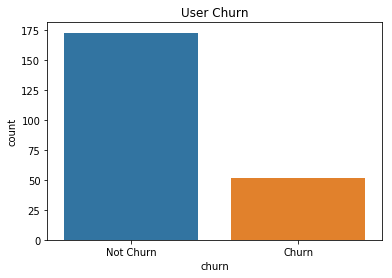

In [36]:
user_churn = udf(lambda x: 'Churn' if x==1 else 'Not Churn')
user_churn_df = df.select(['userId', 'churn']).dropDuplicates()\
        .withColumn('churn', user_churn('churn'))\
        .toPandas()

sns.countplot(x='churn', data=user_churn_df)
plt.title('User Churn')
plt.show()

In [37]:
user_churn_df['churn'].value_counts()

Not Churn    173
Churn         52
Name: churn, dtype: int64

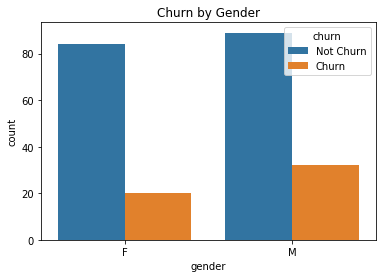

In [38]:
gender_churn = udf(lambda x: 'Churn' if x==1 else 'Not Churn')
gender_df = df.select(['userId', 'gender', 'churn']).dropDuplicates()\
        .withColumn('churn', gender_churn('churn'))\
        .toPandas()

sns.countplot(x='gender', hue='churn', data=gender_df)
plt.title('Churn by Gender')
plt.show()

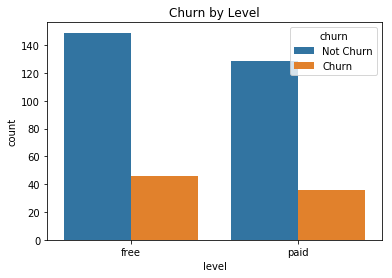

In [39]:
level_churn = udf(lambda x: 'Churn' if x==1 else 'Not Churn')
level_df = df.select(['userId', 'level', 'churn']).dropDuplicates()\
        .withColumn('churn', level_churn('churn'))\
        .toPandas()

sns.countplot(x='level', hue='churn', data=level_df)
plt.title('Churn by Level')
plt.show()

In [40]:
#datetime denotes 0-Monday, 6-Sunday
weekday_func = udf(lambda x: datetime.datetime.fromtimestamp(x/1000.0).weekday(), IntegerType())
df = df.withColumn('weekday', weekday_func(df['ts']))

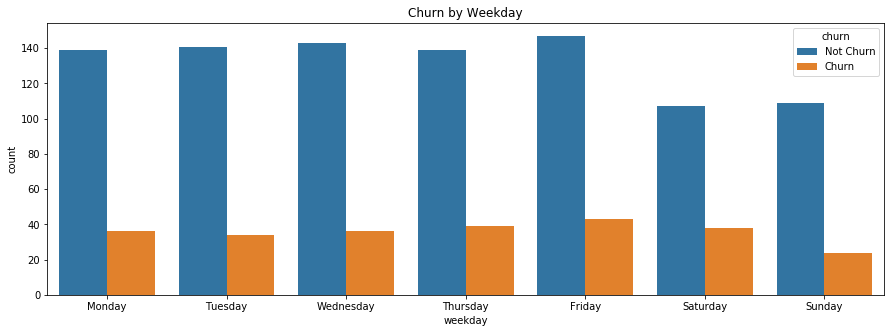

In [41]:
weekday_churn = udf(lambda x: 'Churn' if x==1 else 'Not Churn')
weekday_df = df.select(['userId', 'weekday', 'churn']).dropDuplicates()\
        .withColumn('churn', weekday_churn('churn'))\
        .toPandas()

plt.figure(figsize=(15,5))
sns.countplot(x='weekday', hue='churn', data=weekday_df)
plt.title('Churn by Weekday')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

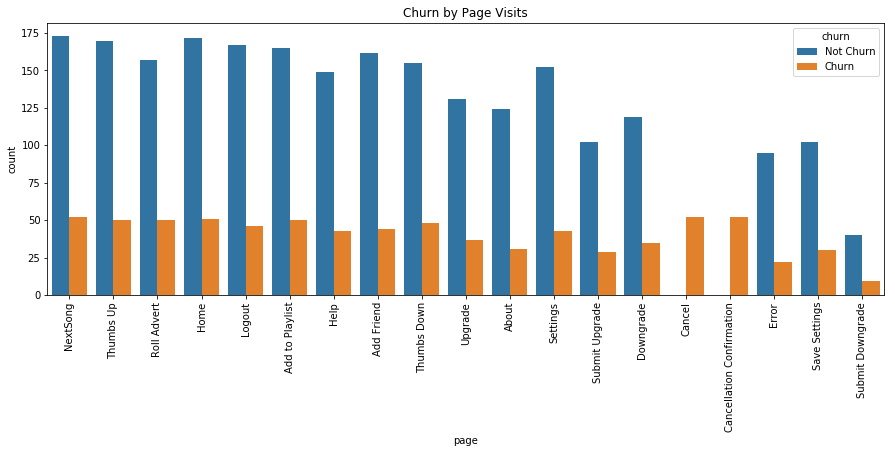

In [42]:
page_churn = udf(lambda x: 'Churn' if x==1 else 'Not Churn')
page_df = df.select(['userId', 'page', 'churn']).dropDuplicates()\
        .withColumn('churn', page_churn('churn'))\
        .toPandas()

plt.figure(figsize=(15,5))
sns.countplot(x='page', hue='churn', data=page_df)
plt.title('Churn by Page Visits')
plt.xticks(rotation=90)
plt.show()

In [43]:
df.select(['location']).dropDuplicates().show()

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [44]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn_event: integer (nullable = true)
 |-- churn: integer (nullable = true)
 |-- weekday: integer (nullable = true)



In [45]:
#Gender
gender_df = df.select(['userId', 'gender'])\
    .dropDuplicates() \
    .orderBy('userId') \
    .replace(['M','F'], ['0', '1'], 'gender')

gender_df.show()

+------+------+
|userId|gender|
+------+------+
|    10|     0|
|   100|     0|
|100001|     1|
|100002|     1|
|100003|     1|
|100004|     1|
|100005|     0|
|100006|     1|
|100007|     1|
|100008|     1|
|100009|     0|
|100010|     1|
|100011|     0|
|100012|     0|
|100013|     1|
|100014|     0|
|100015|     1|
|100016|     0|
|100017|     0|
|100018|     0|
+------+------+
only showing top 20 rows



In [46]:
#Time Registered
time_registered_df = df.select('userId', 'registration', 'ts') \
    .withColumn('time_registered', df['ts'] - df['registration']) \
    .groupBy('userId') \
    .agg({'time_registered':'max'}) \
    .orderBy('userId') \
    .withColumnRenamed('max(time_registered)', 'time_registered')

time_registered_df.show()

+------+---------------+
|userId|time_registered|
+------+---------------+
|    10|     4472293000|
|   100|     5605094000|
|100001|     3870739000|
|100002|    13864787000|
|100003|     1965437000|
|100004|    14898823000|
|100005|     7360899000|
|100006|      788587000|
|100007|     9969490000|
|100008|     5894948000|
|100009|     3234667000|
|100010|     4807612000|
|100011|      446266000|
|100012|     3719746000|
|100013|     3817043000|
|100014|     7351206000|
|100015|     5864764000|
|100016|     6481325000|
|100017|     6815613000|
|100018|     9565527000|
+------+---------------+
only showing top 20 rows



In [47]:
#Subscription level
level_df = df.select(['userId', 'level'])\
    .dropDuplicates() \
    .orderBy('userId') \
    .replace(['free','paid'], ['0', '1'], 'level')

level_df.show()

+------+-----+
|userId|level|
+------+-----+
|    10|    1|
|   100|    0|
|   100|    1|
|100001|    0|
|100002|    1|
|100003|    0|
|100004|    1|
|100004|    0|
|100005|    0|
|100006|    0|
|100007|    1|
|100008|    1|
|100008|    0|
|100009|    1|
|100009|    0|
|100010|    0|
|100011|    0|
|100012|    1|
|100012|    0|
|100013|    0|
+------+-----+
only showing top 20 rows



In [48]:
#Songs Played
numbersongsplayed_df = df.where(df['song'] != 'null') \
    .groupby('userId') \
    .agg(count(df['song']).alias('NumberSongsPlayed')) \
    .orderBy('userId')

numbersongsplayed_df.show()

+------+-----------------+
|userId|NumberSongsPlayed|
+------+-----------------+
|    10|              673|
|   100|             2682|
|100001|              133|
|100002|              195|
|100003|               51|
|100004|              942|
|100005|              154|
|100006|               26|
|100007|              423|
|100008|              772|
|100009|              518|
|100010|              275|
|100011|               11|
|100012|              476|
|100013|             1131|
|100014|              257|
|100015|              800|
|100016|              530|
|100017|               52|
|100018|             1002|
+------+-----------------+
only showing top 20 rows



In [49]:
#Listening Time
listening_time_df = df.select(['userId', 'length']) \
    .groupBy('userId') \
    .sum() \
    .withColumnRenamed('sum(length)', 'listening_time') \
    .orderBy('userId')

listening_time_df.show()

+------+------------------+
|userId|    listening_time|
+------+------------------+
|    10|166866.37251000004|
|   100|  672877.856590001|
|100001|35073.742150000005|
|100002| 49559.91809999999|
|100003|12306.419320000003|
|100004|231480.38928999988|
|100005| 37037.12201000001|
|100006|        5854.89105|
|100007|104495.32492000007|
|100008|191396.79601999995|
|100009|129745.78967999991|
|100010| 66940.89735000003|
|100011|         2841.6995|
|100012|115503.35311000001|
|100013|280391.79410999996|
|100014| 67703.47208000004|
|100015|194617.91655000017|
|100016| 129376.7523399999|
|100017|12261.723399999999|
|100018|248530.32762999993|
+------+------------------+
only showing top 20 rows



In [50]:
#Playlist Adds
playlist_adds_df = df.select(['userId', 'page']) \
    .where(df['page'] == 'Add to Playlist') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'playlist_adds') \
    .orderBy('userId')

playlist_adds_df.show()

+------+-------------+
|userId|playlist_adds|
+------+-------------+
|    10|            9|
|   100|           61|
|100001|            3|
|100002|            5|
|100003|            2|
|100004|           23|
|100005|            3|
|100006|            1|
|100007|            9|
|100008|           30|
|100009|           12|
|100010|            7|
|100011|            2|
|100012|           12|
|100013|           31|
|100014|            7|
|100015|           22|
|100016|            6|
|100017|            1|
|100018|           31|
+------+-------------+
only showing top 20 rows



In [51]:
#User Thumbs Up
thumbs_up_df = df.select(['userId','page']) \
    .where(df['page'] == 'Thumbs Up') \
    .groupBy('userId') \
    .count() \
    .withColumnRenamed('count', 'thumbs_up') \
    .orderBy('userId')

thumbs_up_df.show()

+------+---------+
|userId|thumbs_up|
+------+---------+
|    10|       37|
|   100|      148|
|100001|        8|
|100002|        5|
|100003|        3|
|100004|       35|
|100005|        7|
|100006|        2|
|100007|       19|
|100008|       37|
|100009|       23|
|100010|       17|
|100012|       18|
|100013|       39|
|100014|       17|
|100015|       35|
|100016|       25|
|100017|        2|
|100018|       46|
|100019|        1|
+------+---------+
only showing top 20 rows



In [52]:
#User Thumbs Down
thumbs_down_df = df.select(['userId','page'])\
    .where(df['page'] == 'Thumbs Down')\
    .groupBy('userId')\
    .count()\
    .withColumnRenamed('count', 'thumbs_down')\
    .orderBy('userId')

thumbs_down_df.show()

+------+-----------+
|userId|thumbs_down|
+------+-----------+
|    10|          4|
|   100|         27|
|100001|          2|
|100004|         11|
|100005|          3|
|100006|          2|
|100007|          6|
|100008|          6|
|100009|          8|
|100010|          5|
|100011|          1|
|100012|          9|
|100013|         15|
|100014|          3|
|100015|          8|
|100016|          5|
|100017|          1|
|100018|          9|
|100019|          1|
|100021|          5|
+------+-----------+
only showing top 20 rows



In [53]:
feature_df = df.dropDuplicates(['userId'])\
    .sort('userId')\
    .select(['userId', 'churn'])

features = [gender_df, time_registered_df, level_df, numbersongsplayed_df, listening_time_df, playlist_adds_df, thumbs_up_df, thumbs_down_df]
for feature in features:
    feature_df = feature_df.join(feature, on='userId')

In [54]:
feature_df.show()

+------+-----+------+---------------+-----+-----------------+------------------+-------------+---------+-----------+
|userId|churn|gender|time_registered|level|NumberSongsPlayed|    listening_time|playlist_adds|thumbs_up|thumbs_down|
+------+-----+------+---------------+-----+-----------------+------------------+-------------+---------+-----------+
|100010|    0|     1|     4807612000|    0|              275| 66940.89735000003|            7|       17|          5|
|200002|    0|     0|     6054448000|    0|              387| 94008.87593999993|            8|       21|          6|
|200002|    0|     0|     6054448000|    1|              387| 94008.87593999993|            8|       21|          6|
|   124|    0|     1|    11366431000|    1|             4079|1012312.0927899999|          118|      171|         41|
|    51|    1|     0|     1680985000|    1|             2111| 523275.8428000004|           52|      100|         21|
|     7|    0|     0|     6288035000|    0|              150| 38

In [55]:
for feature in feature_df.columns[1:]:
    feature_df = feature_df.withColumn(feature, feature_df[feature].cast('float'))

In [56]:
feature_df.dtypes

[('userId', 'string'),
 ('churn', 'float'),
 ('gender', 'float'),
 ('time_registered', 'float'),
 ('level', 'float'),
 ('NumberSongsPlayed', 'float'),
 ('listening_time', 'float'),
 ('playlist_adds', 'float'),
 ('thumbs_up', 'float'),
 ('thumbs_down', 'float')]

In [57]:
feature_df.columns

['userId',
 'churn',
 'gender',
 'time_registered',
 'level',
 'NumberSongsPlayed',
 'listening_time',
 'playlist_adds',
 'thumbs_up',
 'thumbs_down']

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

We apply three different classification models:
* Logistic Regression
* Random Forest Classifier
* XBTClassifier

In [113]:
train, test = feature_df.randomSplit([0.8, 0.2], seed=8)
#validation, test = test.randomSplit([0.5, 0.5], seed=8)

#### Logistic Regression

In [114]:
feature_cols = ['gender', 'time_registered', 'level', 'NumberSongsPlayed',
 'listening_time', 'playlist_adds', 'thumbs_up', 'thumbs_down']
assembler = VectorAssembler(inputCols= feature_cols, outputCol='feature_assembler')
scaler = StandardScaler(inputCol='feature_assembler', outputCol='features')
indexer = StringIndexer(inputCol='churn', outputCol='label')

In [52]:
logreg = LogisticRegression(maxIter=10)

pipeline_logreg = Pipeline(stages=[assembler, scaler, indexer, logreg])

paramgrid_logreg = ParamGridBuilder()\
    .addGrid(logreg.regParam, [0.00, 0.05, 0.1])\
    .build()

crossval_logreg = CrossValidator(estimator= pipeline_logreg,
                                estimatorParamMaps= paramgrid_logreg,
                                evaluator=MulticlassClassificationEvaluator(),
                                numFolds=3)

In [53]:
start_time = time()
logreg_cv = crossval_logreg.fit(train)
end_time = time()
print("Training time in seconds:", end_time - start_time)
#training takes roughly 850 seconds/13minutes

Training time in seconds: 865.412047624588


In [54]:
logreg_test_preds = logreg_cv.transform(test)

In [55]:
print("Logistic Regression Metrics")
print("Accuracy:", MulticlassClassificationEvaluator(metricName='accuracy').evaluate(logreg_test_preds))
print("Precision:", MulticlassClassificationEvaluator(metricName='weightedPrecision').evaluate(logreg_test_preds))
print("Recall:", MulticlassClassificationEvaluator(metricName='weightedRecall').evaluate(logreg_test_preds))
print("F1:", MulticlassClassificationEvaluator(metricName='f1').evaluate(logreg_test_preds))

Logistic Regression Metrics
Accuracy: 0.7246376811594203
Precision: 0.7539682539682541
Recall: 0.7246376811594203
F1: 0.6654012443319625


#### Random Forest

In [56]:
rf = RandomForestClassifier()

pipeline_rf = Pipeline(stages=[assembler, scaler, indexer, rf])

paramgrid_rf = ParamGridBuilder()\
    .addGrid(rf.numTrees, [10,20,30])\
    .build()

crossval_rf = CrossValidator(estimator= pipeline_rf,
                                estimatorParamMaps= paramgrid_rf,
                                evaluator=MulticlassClassificationEvaluator(),
                                numFolds=3)

In [57]:
start_time = time()
rf_cv = crossval_rf.fit(train)
end_time = time()
print("Training time in seconds:", end_time - start_time)
#training takes roughly around 880 seconds/14 minutes

Training time in seconds: 895.7618746757507


In [58]:
rf_test_preds = rf_cv.transform(test)

In [59]:
print("Random Forest Metrics")
print("Accuracy:", MulticlassClassificationEvaluator(metricName='accuracy').evaluate(rf_test_preds))
print("Precision:", MulticlassClassificationEvaluator(metricName='weightedPrecision').evaluate(rf_test_preds))
print("Recall:", MulticlassClassificationEvaluator(metricName='weightedRecall').evaluate(rf_test_preds))
print("F1:", MulticlassClassificationEvaluator(metricName='f1').evaluate(rf_test_preds))

Random Forest Metrics
Accuracy: 0.7971014492753623
Precision: 0.8058608058608058
Recall: 0.7971014492753623
F1: 0.7788671023965141


#### Gradient Boosting Trees

In [115]:
gbt = GBTClassifier(maxIter=10)

pipeline_gbt = Pipeline(stages=[assembler, scaler, indexer, gbt])

paramgrid_gbt = ParamGridBuilder()\
    .addGrid(gbt.maxDepth, [5, 10])\
    .build()

crossval_gbt = CrossValidator(estimator= pipeline_gbt,
                                estimatorParamMaps= paramgrid_gbt,
                                evaluator=MulticlassClassificationEvaluator(),
                                numFolds=3)

In [116]:
start_time = time()
gbt_cv = crossval_gbt.fit(train)
end_time = time()
print("Training time in seconds:", end_time - start_time)
#training time took ~1750 seconds/28minutes

Training time in seconds: 1743.210288286209


In [117]:
gbt_test_preds = gbt_cv.transform(test)

In [118]:
print("GBT Metrics")
print("Accuracy:", MulticlassClassificationEvaluator(metricName='accuracy').evaluate(gbt_test_preds))
print("Precision:", MulticlassClassificationEvaluator(metricName='weightedPrecision').evaluate(gbt_test_preds))
print("Recall:", MulticlassClassificationEvaluator(metricName='weightedRecall').evaluate(gbt_test_preds))
print("F1:", MulticlassClassificationEvaluator(metricName='f1').evaluate(gbt_test_preds))

GBT Metrics
Accuracy: 0.8115942028985508
Precision: 0.8117138364779874
Recall: 0.8115942028985507
F1: 0.8013468013468015


#### Best Model

In [119]:
gbt_cv.bestModel.stages[-1]

GBTClassificationModel (uid=GBTClassifier_db1c625d6888) with 10 trees

In [120]:
gbt_cv.bestModel.stages[-1].featureImportances.values

array([ 0.00793723,  0.39450263,  0.00124895,  0.14718251,  0.01071992,
        0.14299351,  0.07859218,  0.21682307])

In [121]:
train.columns

['userId',
 'churn',
 'gender',
 'time_registered',
 'level',
 'NumberSongsPlayed',
 'listening_time',
 'playlist_adds',
 'thumbs_up',
 'thumbs_down']

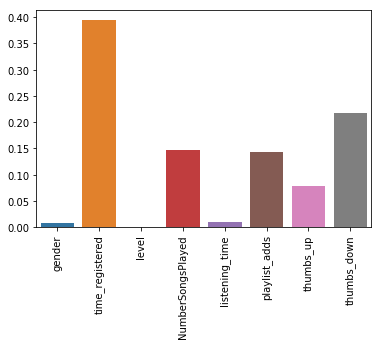

In [122]:
features = train.columns[2:]
featureimportances = gbt_cv.bestModel.stages[-1].featureImportances.values

sns.barplot(x=features, y=featureimportances)
plt.xticks(rotation=90)
plt.show()

Looking at the feature importances of our best gradient boosting model, we see that the time registered played the most important role in predicting user churn.

### Conclusion
The goal of this project was to implement data-driven strategies to predict customer churn from the digital music streaming service Sparkify. By understanding the behavior of their customers, Sparkify can make changes to their platform to increase their business performance and figure out ways to improve customer experiences. By implementing the logistic regression, random forest, and gradient boosting machine learning models, we were able to predict whether or not a user would churn.

Using our best model, the gradient boosting classifier, we visualized the importance of each of the features to see which features played the largest factors for predicting a user will churn. It was very interesting to see that the most important features to predict user churn was the amount of time the user was registered as well as user engagement features like the amount of times they thumbs up or thumbs down, or the amount of songs they have added on their playlists. Perhaps, the more a user did a thumbs down the higher chance they were likely to churn and leave the platform. It was also interesting that gender or the subscription level did not play a larger role in the model’s predictive importance.